In [1]:
# 挂载 google 云盘
from google.colab import drive
drive.mount('/content/gdrive')

# 将文件路径指定为数据路径
import os
os.chdir('/content/gdrive/My Drive/comment')

import numpy as np
import pandas as pd

from tqdm import tqdm #显示运行进度条

# 画图库
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
import matplotlib.pyplot as plt

# 文字处理库
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
# nltk.download('stopwords') #下载停止词
import string
from keras.preprocessing import sequence
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve,auc,roc_auc_score
from keras.preprocessing.text import text_to_word_sequence

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Using TensorFlow backend.


In [2]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
nltk.download('stopwords') #下载停止词
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


all_comments = pd.concat([train_data['comment_text'], test_data['comment_text']])
stop_words = set(stopwords.words('english'))

comments_refined = []
print('正在处理文本......')
for line in tqdm(all_comments):
    word_seq = text_to_word_sequence(line,
                              filters=string.punctuation+'\n\t0123456789',
                              lower=True,
                              split=" ")
    comments_refined.append(' '.join([word for word in word_seq if word not in stop_words]))
vectorizer = TfidfVectorizer( strip_accents='unicode',
                              analyzer='word',
                              use_idf=True,
                              smooth_idf=True,
                              sublinear_tf=True,
                              max_features=50000
                              ).fit(comments_refined)
train_features, test_features = map(lambda x: vectorizer.transform(tqdm(x)), 
                                    [train_data['comment_text'], 
                                     test_data['comment_text']])

print('文本处理完成！')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  1%|          | 2063/312735 [00:00<00:15, 20628.05it/s]

正在处理文本......


100%|██████████| 153164/153164 [00:09<00:00, 16777.59it/s]


文本处理完成！


  0%|          | 0/6 [00:00<?, ?it/s]

在toxic类上的分类准确率为0.9592


 17%|█▋        | 1/6 [00:26<02:14, 26.80s/it]

在severe_toxic类上的分类准确率为0.9906


 33%|███▎      | 2/6 [00:55<01:49, 27.48s/it]

在obscene类上的分类准确率为0.9781


 50%|█████     | 3/6 [01:21<01:20, 26.89s/it]

在threat类上的分类准确率为0.9973


 67%|██████▋   | 4/6 [01:46<00:52, 26.33s/it]

在insult类上的分类准确率为0.9720


 83%|████████▎ | 5/6 [02:13<00:26, 26.62s/it]

在identity_hate类上的分类准确率为0.9922


100%|██████████| 6/6 [02:39<00:00, 26.33s/it]


平均准确率为0.9816


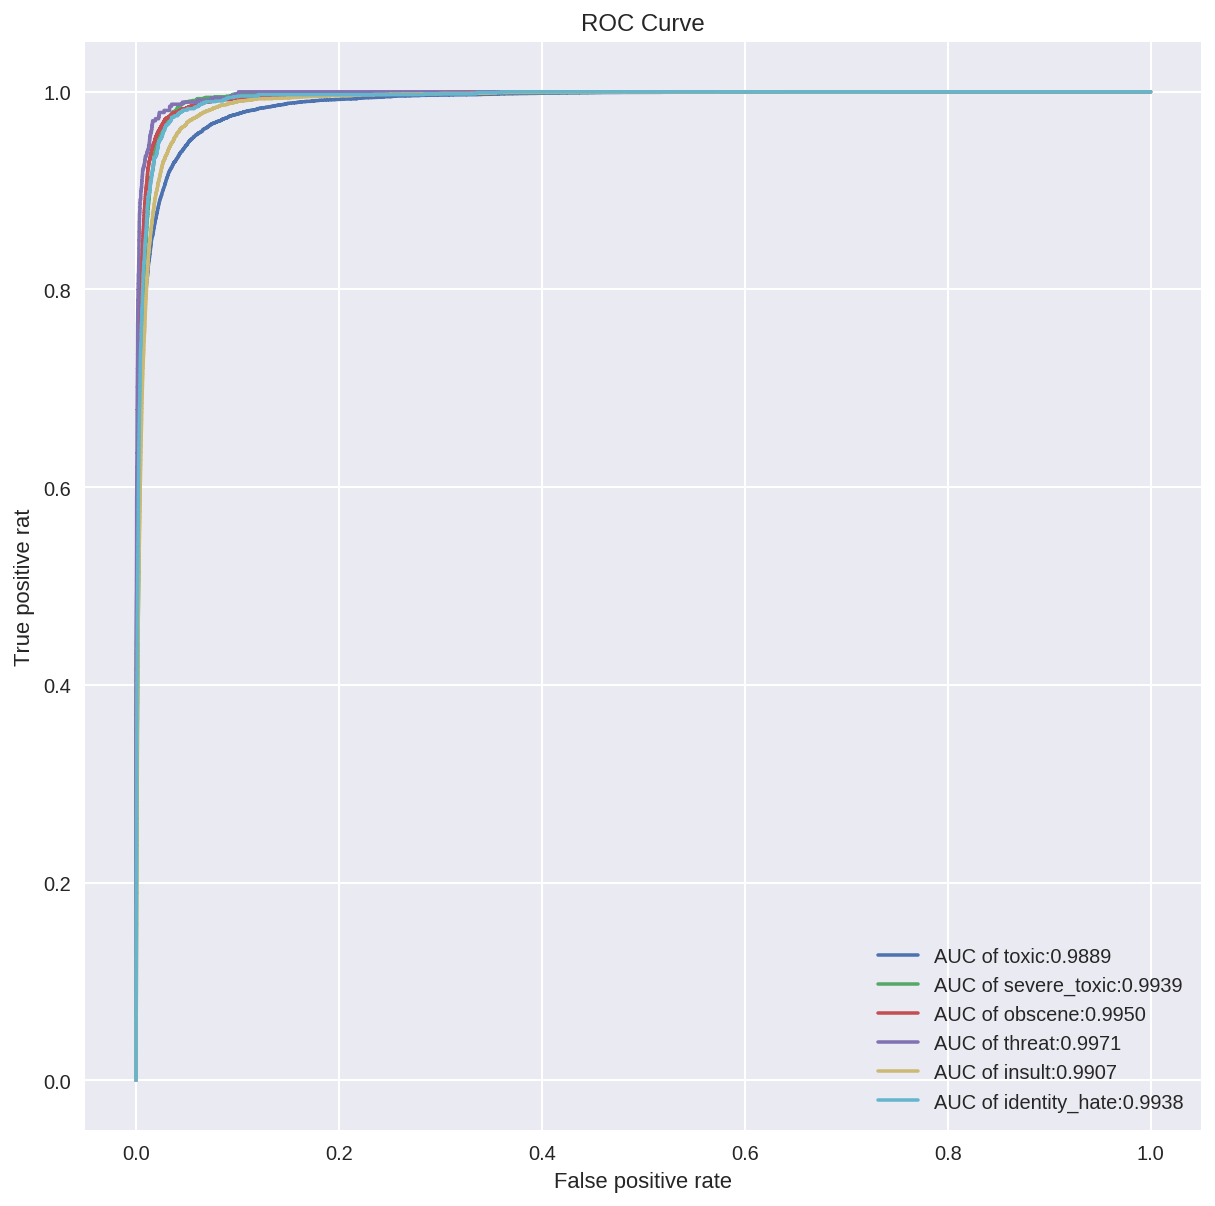

100%|██████████| 6/6 [00:00<00:00, 31.33it/s]


In [6]:
class_dict = {}
acc_scores = []
plt.figure(figsize=(10,10))
for label in tqdm(labels):
    classifier = LogisticRegression(C=5,
                                    solver='sag'
                                   )
    acc_scores.append(cross_val_score( classifier, 
                                       train_features, 
                                       train_data[label], 
                                       cv=5, 
                                       scoring='accuracy'))
    print('在{}类上的分类准确率为{:.4f}'.format(label, np.mean(acc_scores[-1])))
    classifier.fit(train_features, train_data[label])
    probs = classifier.predict_proba(train_features)[:,1]
    fpr,tpr,thres = roc_curve(train_data[label],probs)
    area =roc_auc_score(train_data[label],probs)
    plt.plot(fpr,tpr,label= 'AUC of {}:{:.4f}'.format(label, area))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rat')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    class_dict[label] = classifier
print('平均准确率为{:.4f}'.format(np.mean(acc_scores)))
plt.show()

submission = pd.DataFrame.from_dict({'id': test_data['id']})
for label in tqdm(labels):
  submission[label] = class_dict[label].predict_proba(test_features)[:,1]
submission.to_csv('LR.csv', index=False)

In [0]:
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
train = pd.read_csv('train.csv').fillna(' ')
test = pd.read_csv('test.csv').fillna(' ')
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

submission = pd.DataFrame.from_dict({'id': test['id']})

for class_name in class_names:
    train_target = train[class_name]
    classifier = Ridge(alpha=5, 
                       copy_X=True, 
                       fit_intercept=True, 
                       solver='auto')
#     classifier = RidgeClassifier(alpha=5,
#                                  solver='auto')
    classifier.fit(train_features, train_target)
    submission[class_name] = classifier.predict(test_features)
submission.to_csv('RIDGE.csv', index=False)